### The invariant distribution and the numerical simulation at "infinite" times
In this section, I am interested in comparing a numerical approximation to the infinite double well SDE at infinite time to its invariant distribution. 

The Hamiltonian of a bounded system can be written as:
$$
    dX_j = - \nabla V(X_j) dt + \sqrt{2 \tau} dB_j.
$$
where $V(x) = \frac{1}{2x^2}+x^2$. 

To do so, I design a code using numba that simulates one path of a numerical approximation of the SDE (using Euler Maruyama) and follow this path for a very long time. Using ergodicity, the distribution of the samples of this path should converge to the invariant distribution. 

This piece of code will go through the different parameter that can vary and look at how they impact how the distribution of the simulated path is close to the invariant distribution. 

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

In [3]:
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import numpy as np
import time

nb.__version__

'0.55.2'

### Numba code

The functions below are written using numba. 

In [18]:
# define the gradV function 
@njit(float64(float64))
def dU(x):
    """
    Compute the potential of the infinite double well:
    x: float 
    """

    return -1/(x*x*x)+2*x

@njit(float64(float64,float64,float64,float64))
def e_m_fast(y0,s,b1,dt):
    """
    The Euler-Maruyama scheme applied to the infinite double well
    y0: float
        value of y at t_n
    tau: float
        value of the temperature 
    b1: float
        brownian increment 
    dt: float
        time increment
    """
    y1=y0 - dU(y0)*dt+s*b1
    return y1    
    

    
# @njit(float64(float64,float64,float64,float64))
# def run_num(y0,s,dt,N):
#     """
#     Run the simulation for one sample path
#     Input
#     -----
#     N: int
#         Number of steps taken in T=1 sec
#     dt: float 
#         Value of time increment. Is 1/N.
#     s: float 
#         Is sqrt(2 \tau). 
#     T: int
#         Final time
#     Return
#     ------
#     yf: float
#         Value of X(T) as approximated by the numerical scheme chosen
        
#     """
#     for ii in range(N):
#         b1 = np.random.normal(0,1,1)[0]
#         y1 = e_m_fast(y0,s,b1,dt)
#         y0=y1 
#     return y1



@njit() #float64[:](float64,float64,float64,float64))
def DW_sde_fast(N,dt,tau): # Function is compiled and runs in machine code
    """
    Input
    -------
    n_samples: int
        Number of sample to draw
    T: int 
        Final time
    N: int
        Number of time steps 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    method: function
        Numerical scheme used for the DW SDE
    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """
    y_final = [] #np.zeros(n_samples)
    s = np.sqrt(2*tau*dt)
    n_esc=0
    y0 = 2 #initial condition
    for jj in range(N): # Run until T= Tsec
        b1 = np.random.normal(0,1,1)[0]
        y1 = e_m_fast(y0,s,b1,dt)
        y0=y1 
        y_final.append(y1)
    y_final=np.array(y_final)
    return y_final

%time y_compile = DW_sde_fast(10**8,10**(-6),0.001) # compile the function


CPU times: user 12.4 s, sys: 171 ms, total: 12.6 s
Wall time: 12.6 s


The potential is defined below in order to be able to plot the invariant distribution, which has the form: $\rho_{\infty} = C \exp \left(-\frac{V(x)}{\tau}\right)$


In [6]:
def U(x):
    """
    potential of -the infinite double well
    """

    return (1/(2*x**2)+x*x)


## Show how numerical simulations is different from histogram

I want to show how the numerical simulation compares to the invariant distribution. In particular, I am interested by how the time increment $\Delta t$, the temperature $\tau$ and the final time $T_f$ impacts this difference. 

### Different values of the time increment  
Below I am looking at varying the time discretisation parameter $\Delta t$. We expect that as the time discretisation parameter decreases, the numerical error should decreases as well and the distribution of the simulated sample path should be closer to the invariant distribution. For this simulation, we use the value of the temperature at $\tau = 0.01$, and set the number of simulation to $N$. 

In [33]:
## Plot results on the simulation
N=10**7
tau=0.01
dt_list=[0.5,0.2,0.1,10**(-2),10**(-3),10**(-4)]

# empty vector to save results
y_res = []
for i in range(len(dt_list)):
    dti=dt_list[i]
    y_exact = DW_sde_fast(N,dti,tau)
    y_res.append(y_exact)
    

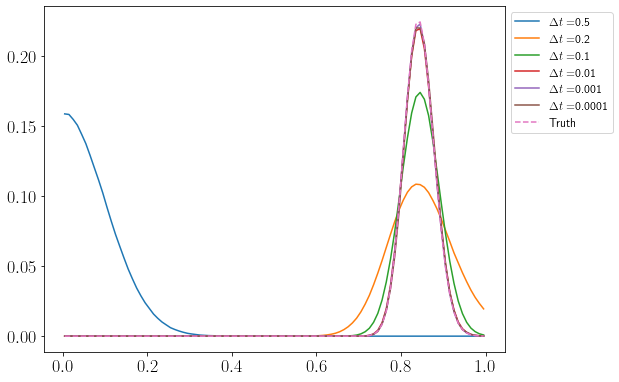

In [34]:
# axis of the plot 
fig, (ax)= plt.subplots(1, 1,figsize=(8,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


## Plot 1 
for i in range(len(dt_list)):
    ye = y_res[i]
    dti = dt_list[i]
    histogram,bins = np.histogram(ye,bins=100,range=[0,1], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    ax.plot(midx,histogram,label='$\Delta t=$'+str(dti))
    
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- (U(midx)/tau))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
rho=(rho/np.sum(rho))*2
ax.plot(midx,rho,'--',label='Truth')      
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# ax.set_ylim(0,0.125)



It is interesting to see that as the time discretisation $\Delta t$ decreases, the distribution get closer to the invariant distribution. Something interesting happens with an increment $\Delta t =0.5$. It seems that this value triggers a different convergence to the invariant distribution. This value is definitely too high to allow Euler-Maruyama to converge. Similarly, the time interval $\Delta t = 0.1$ and $\Delta t=0.1$ does not allow convergence toward the invariant distribution. 

In [35]:
## Plot results on the simulation
N=10**7
tau=0.01
dt_list=[0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,10**(-2)]

# empty vector to save results
y_res = []
for i in range(len(dt_list)):
    dti=dt_list[i]
    y_exact = DW_sde_fast(N,dti,tau)
    y_res.append(y_exact)

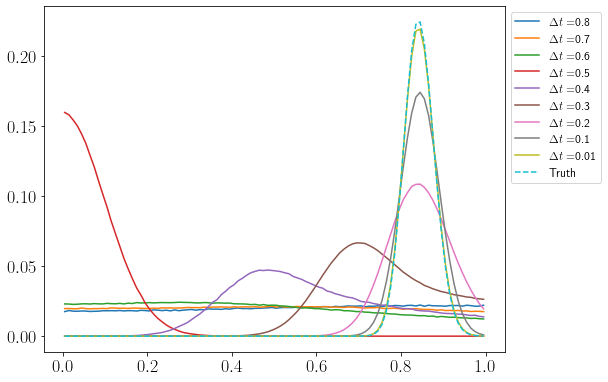

In [36]:
# axis of the plot 
fig, (ax)= plt.subplots(1, 1,figsize=(8,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


## Plot 1 
for i in range(len(dt_list)):
    ye = y_res[i]
    dti = dt_list[i]
    histogram,bins = np.histogram(ye,bins=100,range=[0,1], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    ax.plot(midx,histogram,label='$\Delta t=$'+str(dti))
    
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- (U(midx)/tau))
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
rho=(rho/np.sum(rho))*2
ax.plot(midx,rho,'--',label='Truth')      
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
# ax.set_ylim(0,0.125)



### Different values of the temperature  
Below I am looking at varying the temperature parameter $\tau$. We expect that as the temperature increases, the error should increase. The distribution of the simulated sample path should be further to the invariant distribution. For this simulation, we use the value of the time discretisation $\Delta t = 0.01$.

In [91]:
## Plot results on the simulation
N = 10**8
dt=0.01
tau_list = [0.1,0.5]+[i for i in range(1,9)]

# empty vector to save results
y_res_tau = np.zeros((len(tau_list),N))

#run through the different values of tau 
for i in range(len(tau_list)):
    tau_i=tau_list[i]
    y_exact = DW_sde_fast(N,dt,tau_i)
    y_res_tau[i,::]=y_exact
    

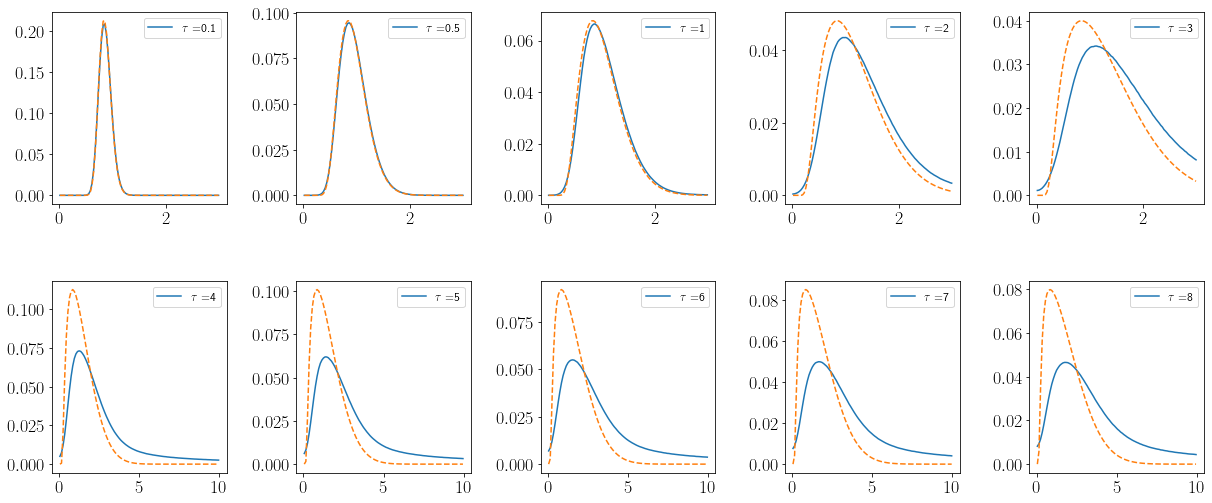

In [93]:
# axis of the plot 
fig, (axs)= plt.subplots(2, 5,figsize=(20,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



## Plot 1 
for i in range(len(tau_list)):

    ye = y_res_tau[i,::] #exctract the result of interest from the list
    tau_i = tau_list[i] #exctract the value of tau of interest from the list 


    # value of the indexes for the plot and bounds for histograms
    bounds=[0,3]
    j=0
    if i>4:
        j=1
        i= i-5
        bounds=[0,10]

    histogram,bins = np.histogram(ye,bins=100,range=bounds, density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    axs[j,i].plot(midx,histogram,label='$\\tau =$'+str(tau_i))
    axs[j,i].legend() #add the legend

    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- (U(midx)/tau_i))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    axs[j,i].plot(midx,rho,'--',label='Truth')   
    

In the plot above, one can see that when the temperature increases, the distribution on the long term does not converge to the invariant distribution anymore. The two distributions are not similar. When the time discretisation is set to $\Delta t=0.01$, the change seems to happen between the value of the temperature $\tau-0.1$ and $\tau=2$. 

In [106]:
## Plot results on the simulation
N = 10**7
dt=0.01
tau_list = np.round(np.arange(0.5,2,0.1),3)
# empty vector to save results
y_res_tau = np.zeros((len(tau_list),N))

#run through the different values of tau 
for i in range(len(tau_list)):
    tau_i=tau_list[i]
    y_exact = DW_sde_fast(N,dt,tau_i)
    y_res_tau[i,::]=y_exact

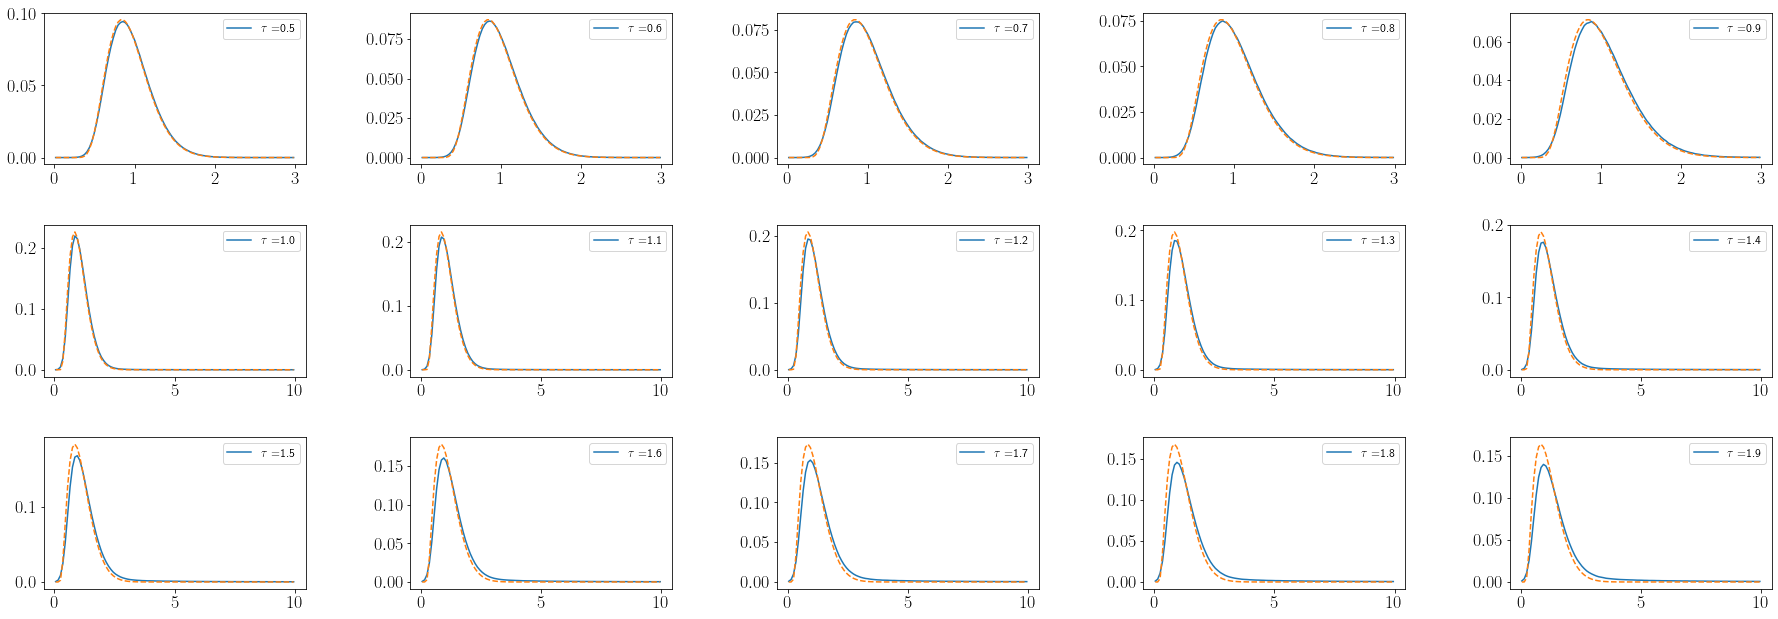

In [107]:
# axis of the plot 
fig, (axs)= plt.subplots(3, 5,figsize=(30,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



## Plot 1 
for i in range(len(tau_list)):

    ye = y_res_tau[i,::] #exctract the result of interest from the list
    tau_i = tau_list[i] #exctract the value of tau of interest from the list 


    # value of the indexes for the plot and bounds for histograms
    bounds=[0,3]
    j=0
    if i>9:
        j=2
        i= i-10
        bounds=[0,10]
    elif i>4:
        j=1
        i= i-5
        bounds=[0,10]

    #Histograms
    histogram,bins = np.histogram(ye,bins=100,range=bounds, density=True)
    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))*2
    axs[j,i].plot(midx,histogram,label='$\\tau =$'+str(tau_i))
    axs[j,i].legend() #add the legend

    midx = (bins[0:-1]+bins[1:])/2
    rho = np.exp(- (U(midx)/tau_i))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    axs[j,i].plot(midx,rho,'--',label='Truth')  

When looking more in details into in which range of values of $\tau$ are interesting, we seen that the divergence from the true distribution is appearant between 0.5 and 2 for a time discretisation parameter of $\Delta t=0.01$.